In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.optim.lr_scheduler import ExponentialLR

from binarypredictor.datagen import PolyGenerator, DataGenerator
from binarypredictor.poly import Polynomial, PolynomialSet, PolynomialBatch, PolynomialDataLoader
from binarypredictor.net import DerivativeNet

In [2]:
# Create dataset
dg = DataGenerator()
dg.generate_data(20000)

polys = dg.get_polys()

batch_size = 200
train_loader = PolynomialDataLoader(polys, batch_size, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:57<00:00, 169.65it/s]


In [3]:
out_features = 50
lr = 1e-3

net_p = DerivativeNet(train=True, in_features=100, hidden_size_linear=256, out_features=out_features, hidden_layers=1)
net_q = DerivativeNet(train=True, in_features=100, hidden_size_linear=256, out_features=out_features, hidden_layers=1)
optimizer_p = torch.optim.Adam(net_p.parameters(), lr=lr)
optimizer_q = torch.optim.Adam(net_q.parameters(), lr=lr)
#scheduler = ExponentialLR(optimizer, gamma=0.995)

In [7]:
low, high = 0., 1.

x_in = torch.arange(low, high, step=0.01 * (high - low))
x_out = torch.zeros((batch_size, out_features))
x_out[:] = torch.arange(low, high, step=1/out_features * (high - low))

for i in range(5000):
    for p in train_loader:
        inp = p.get_values(x_in, o=0, stack='h')
        out_p = net_p(inp[:, :, 0].squeeze().float())
        out_q = net_q(inp[:, :, 1].squeeze().float())
                        
        x_range = torch.stack((out_p, out_q), dim=2)
        p_vals = p.get_values(x_range)
        dp_vals = p.get_values(x_range, o=1)

        optimizer_p.zero_grad(), optimizer_q.zero_grad()
        loss = nn.MSELoss()(p_vals[:, :, 0] - out_p * dp_vals[:, :, 0], p_vals[:, :, 1] - out_q * dp_vals[:, :, 1])
        loss.backward(retain_graph=True)
        optimizer_p.step()
        optimizer_q.step()
    #scheduler.step()
    
    if i % 5 == 0:
        print(loss)

KeyboardInterrupt: 

In [7]:
#torch.save(net_q, 'binary_q.pth')

In [5]:
net_p = torch.load('binary_p.pth')
net_q = torch.load('binary_q.pth')

In [17]:
pg = PolyGenerator(2)
pg.add_constraint(0.5, 1, 0)
pg.add_constraint(0.1, 0, 1)
#pg.add_constraint(0.8, 0, 1)
pg.add_constraint(0.5, 0, 0)
#pg.add_constraint(0.9, 0, 5)
#pg.add_constraint(0.2, 0, 2.5)

qg = PolyGenerator(2)
qg.add_constraint(0.5, 1, 0)
qg.add_constraint(0.1, 0, 2)
qg.add_constraint(0.5, 0, -.2)
#qg.add_constraint(0.9, 1, -6)
#qg.add_constraint(0.9, 0, 8)
#qg.add_constraint(0.2, 0, 1.5)

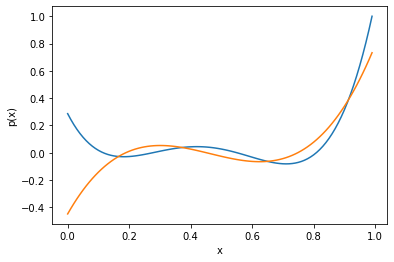

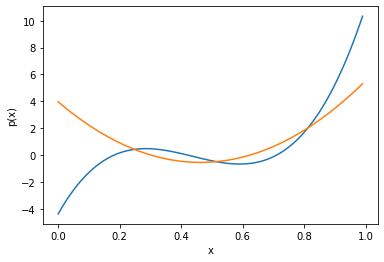

In [24]:
x_in = torch.arange(low, high, step=0.01 * (high - low))

poly_set = train_loader[0][6]
#poly_set = PolynomialSet() 
#poly_set.append(Polynomial(pg.get_cfs())) 
#poly_set.append(Polynomial(qg.get_cfs()))

d_poly_set = poly_set.get_derivatives()

#poly_set.scale_by_max(x_in)
poly_set.plot(x_in)
plt.show()

d_poly_set.plot(x_in)
plt.show()

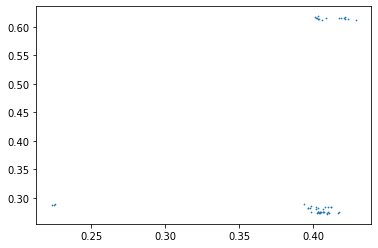

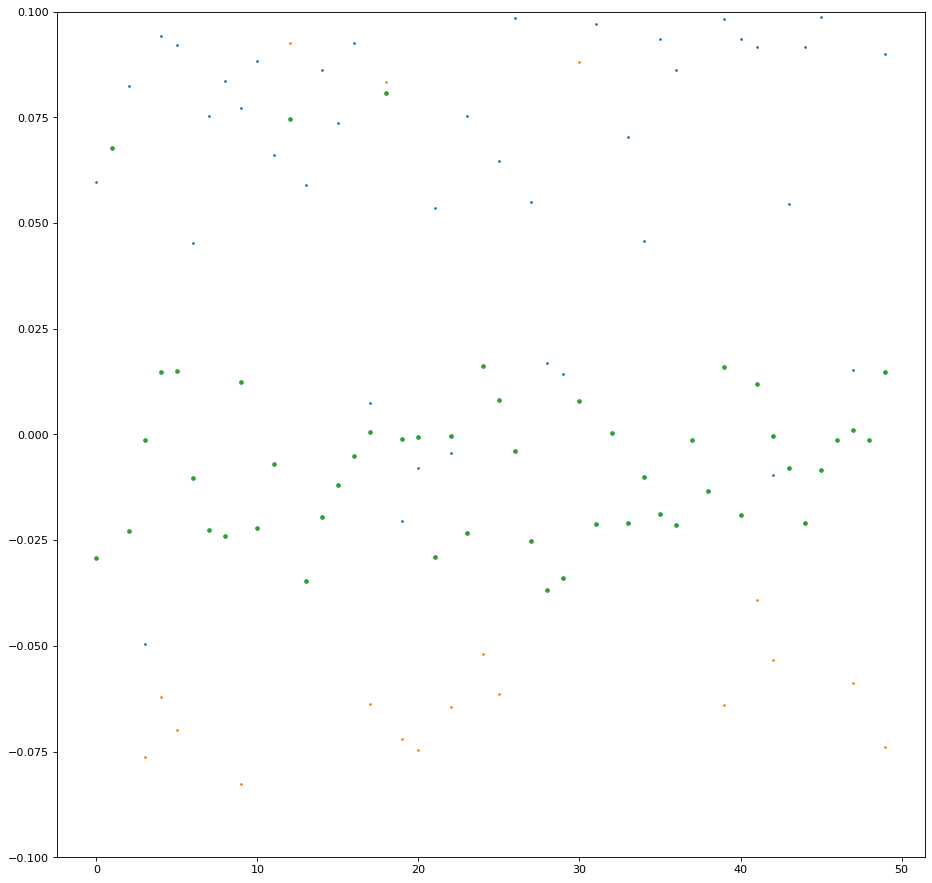

In [25]:
inp = poly_set.get_values(x_in, stack='h')

out_p = (net_p(inp[:, 0].squeeze().float()))
out_q = (net_q(inp[:, 1].squeeze().float()))

plt.scatter(out_p.detach(), out_q.detach(), s=.5)
plt.show()

x_range = torch.vstack((out_p, out_q)).T
dp_vals = d_poly_set.get_values(x_range)
plt.figure(figsize=(14, 14), dpi=80)
plt.scatter(range(len(out_p)), dp_vals[:, 0].detach(), s=2)
plt.scatter(range(len(out_q)), dp_vals[:, 1].detach(), s=2)
plt.scatter(range(len(out_q)), ((dp_vals[:, 0] - dp_vals[:, 1])*torch.max(dp_vals, dim=-1)[0]).detach(), s=10)
plt.ylim(-.1, .1)
plt.show()

In [20]:
eqns_ = poly_set.get_values(x_range) - x_range * d_poly_set.get_values(x_range)
eqn_poly_set_ = PolynomialSet()
eqn_poly_set_.from_values(x_range, eqns_)

In [21]:
idx = torch.where((abs((dp_vals[:, 0] - dp_vals[:, 1])) < .5e-1) & (abs(eqns_[:, 0] - eqns_[:, 1]) < 1e-1))[0]
print(idx)

tensor([], dtype=torch.int64)


In [22]:
if len(idx) > 0:
    
    xpq = x_range[idx]
    print(xpq)
    
    xp, xq = xpq[:, 0], xpq[:, 1]

    print(*zip(xp.detach().numpy(), xq.detach().numpy()))
    y = poly_set.get_values(xpq)
    poly_set.plot(x_in)
    plt.plot([xp.detach().numpy(), xq.detach().numpy()], [y[:, 0].detach().numpy(), y[:, 1].detach().numpy()], marker='o')
    plt.show()
    
    for xp_, xq_, y_ in zip(xp, xq, y):
        poly_set.plot(x_in)
        plt.plot([xp_.detach().numpy(), xq_.detach().numpy()], [y_[0].detach().numpy(), y_[1].detach().numpy()], marker='o')
        plt.show()
else:
    print('No common tangents!')

No common tangents!


In [23]:
print(eqn_poly_set_.get_values(xpq))
print(d_poly_set.get_values(xpq))

tensor([[ 0.3975, -2.0270],
        [ 0.5128,  1.8258],
        [ 0.5174,  1.8244],
        [ 0.5321,  1.8165],
        [ 0.5393,  1.8280],
        [ 0.4307, -2.0963],
        [ 0.5400,  1.8284],
        [ 0.5359,  1.8261]], grad_fn=<CatBackward0>)
tensor([[-0.8868,  3.1025],
        [-1.2092, -5.9678],
        [-1.2230, -5.9586],
        [-1.2671, -5.9073],
        [-1.2892, -5.9824],
        [-0.9759,  3.2007],
        [-1.2913, -5.9846],
        [-1.2788, -5.9697]], grad_fn=<CatBackward0>)
